# Plot smoothing functions used in canonicalization

This notebook extracts the smoothing function used in `make_canon_ops` in `utils.gpave` and produces Figure 4 of the main paper and Figure 10 - 14 of the appendix.

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt 
import functools

plt.rcParams.update({ 
    "text.usetex": True,
    "font.weight": "heavy",
    "font.size": 10,
    "text.latex.preamble": r"\usepackage{amsmath}"
})

stability_eps = 0
where_trick = lambda x: jnp.where(x > 0., x, 1.)

def phi(x):
    return jnp.where(x > 0. + stability_eps, jnp.exp(-1/where_trick(x)),  0.)

def smoothed_step(w):
    return phi(w) / (phi(w) + phi(1-w))

def two_step(w):
    return jnp.where(w <= 0, 0., 
                jnp.where(w <= 1/3, 9 * w**3 / 2,
                    jnp.where(w <= 2/3, 9*(w-1)**3/2 - (3*w -2)**3 / 2 + 1,
                        jnp.where(w <= 1, 9*(w-1)**3/2 + 1,
                            1.),),),)

def lamb(step_fn, eps, w):
    return step_fn( 1 - w / eps )


def d(step_func, x):
    tilde_s = lambda x: x * step_func(x)
    return tilde_s(2*(x-1)) + tilde_s(- 2*x)


def weight_minus_one(step_func, eps, x):
    return lamb(step_func, eps, d(step_func, x-1))

def weight(step_func, eps, x):
    return lamb(step_func, eps, d(step_func, x))

def weight_add_one(step_func, eps, x):
    return lamb(step_func, eps, d(step_func, x+1))

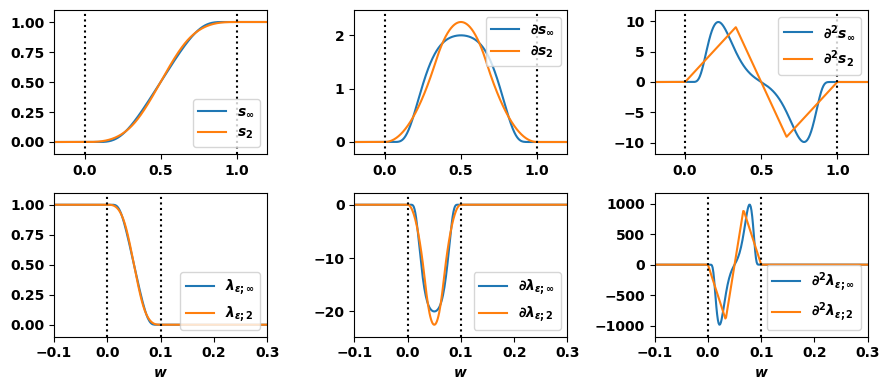

In [4]:
eps = 0.1 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 4)) 

lamb_inf = functools.partial(lamb, smoothed_step, eps)
lamb_two = functools.partial(lamb, two_step, eps)

labels = [
            [
                [r'$s_{\infty}$', r'$s_{2}$'], 
                [r'$\partial s_{\infty}$', r'$\partial s_{2}$'], 
                [r'$\partial^2 s_{\infty}$', r'$\partial^2 s_{2}$']  
            ],
            [
                [r'$\lambda_{\epsilon;\infty}$', r'$\lambda_{\epsilon;2}$'], 
                [r'$\partial\lambda_{\epsilon;\infty}$', r'$\partial\lambda_{\epsilon;2}$'], 
                [r'$\partial^2\lambda_{\epsilon;\infty}$', r'$\partial^2\lambda_{\epsilon;2}$']  
            ]
]

for i, funcs in enumerate([[smoothed_step, two_step], [lamb_inf, lamb_two]]):
    for j in range(3):
        xs = jnp.linspace(-0.2, 1.2, 1000)
        f_inf = funcs[0]
        f_two = funcs[1]
        for k in range(j):
            f_inf = jax.grad(f_inf)
            f_two = jax.grad(f_two)
        f_inf_xs = jax.vmap(f_inf)(xs)
        f_two_xs = jax.vmap(f_two)(xs)
        
        axes[i,j].plot(xs, f_inf_xs, label=labels[i][j][0])
        axes[i,j].plot(xs, f_two_xs, label=labels[i][j][1])
        
        ymin = min(jnp.min(f_inf_xs), jnp.min(f_two_xs))
        ymax = max(jnp.max(f_inf_xs), jnp.max(f_two_xs))
        yrange = ymax - ymin
        ypad = yrange * 0.1
        
        if i == 1 or j == 0:
            axes[i,j].legend(loc='lower right')
        else:
            axes[i,j].legend(loc='upper right')
        axes[i,j].set_ylim([ymin - ypad, ymax + ypad])
        if i == 0:
            axes[i,j].vlines([0.,1.], ymin - ypad, ymax + ypad, colors='black', linestyles='dotted')
            axes[i,j].set_xlim([-0.2,1.2])
        else:
            axes[i,j].vlines([0.,eps], ymin - ypad, ymax + ypad, colors='black', linestyles='dotted')
            axes[i,j].set_xlim([-0.1,0.3])

for j in range(3):
    axes[1,j].set_xlabel(r'$w$')

plt.tight_layout()

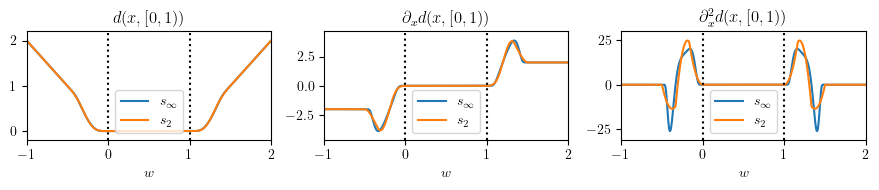

In [ ]:
import matplotlib.pyplot as plt 
import functools

plt.rcParams.update({ 
    "text.usetex": True,
    "font.weight": "heavy",
    "font.size": 10,
    "text.latex.preamble": r"\usepackage{amsmath}"
})


fig, axes = plt.subplots(ncols=3, figsize=(9, 2), sharex=True) 

for j in range(3):
    xs = jnp.linspace(-1.0, 2.0, 1000)
    f_inf = functools.partial(d, smoothed_step)
    f_two = functools.partial(d, two_step)
    for k in range(j):
        f_inf = jax.grad(f_inf)
        f_two = jax.grad(f_two)
    f_inf_xs = jax.vmap(f_inf)(xs)
    f_two_xs = jax.vmap(f_two)(xs)
    
    axes[j].plot(xs, f_inf_xs, label=r'$s_\infty$')
    axes[j].plot(xs, f_two_xs, label=r'$s_2$')
    
    ymin = min(jnp.min(f_inf_xs), jnp.min(f_two_xs))
    ymax = max(jnp.max(f_inf_xs), jnp.max(f_two_xs))
    yrange = ymax - ymin
    ypad = yrange * 0.1
    axes[j].vlines([0.,1.], ymin - ypad, ymax + ypad, colors='black', linestyles='dotted')
    
    axes[j].legend(loc='lower center')
    axes[j].set_ylim([ymin - ypad, ymax + ypad])
    axes[j].set_xlim([-1.0,2.0])

for j in range(3):
    axes[j].set_xlabel(r'$w$')

axes[0].set_title(r'$d(x,[0,1))$')
axes[1].set_title(r'$\partial_x d(x,[0,1))$')
axes[2].set_title(r'$\partial_x^2 d(x,[0,1))$')

plt.tight_layout()

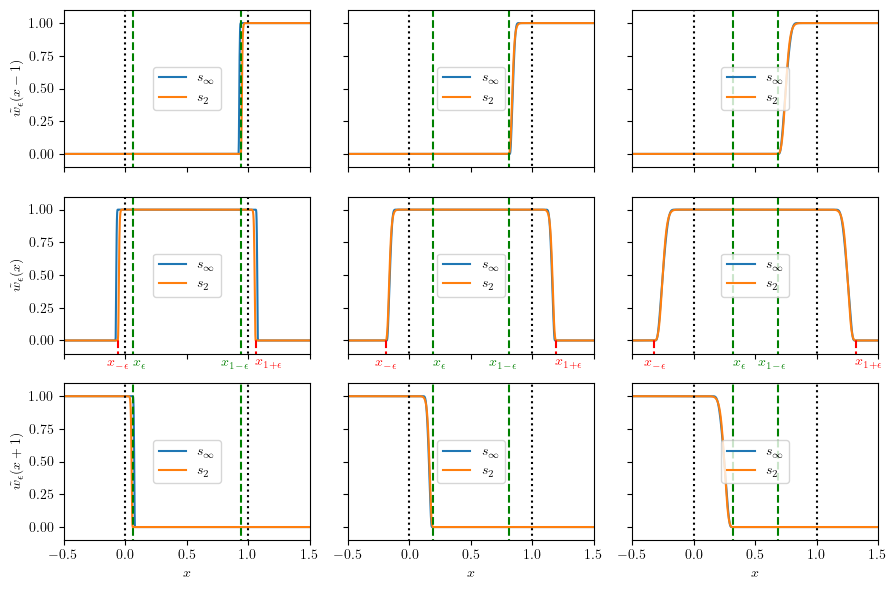

In [66]:
import functools
import numpy as np


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 6), sharex=True, sharey=True) 

cutoff_markers = np.zeros((3,3,2,2))

for i, w in enumerate([weight_minus_one, weight, weight_add_one]):
    for j, eps_str in enumerate(['1e-3', '1e-1', '5e-1']):
        eps = float(eps_str)
        xs = jnp.linspace(-0.5, 1.5, 1000)
        w_lamb_inf_xs = jax.vmap(functools.partial(w, smoothed_step, eps))(xs)
        w_lamb_two_xs = jax.vmap(functools.partial(w, two_step, eps))(xs)
        axes[i,j].plot(xs, w_lamb_inf_xs, label=r'$s_\infty$')
        axes[i,j].plot(xs, w_lamb_two_xs, label=r'$s_2$')
        axes[i,j].vlines([0.,1.], -10.1, +10.1, colors='black', linestyles='dotted')
        axes[i,j].legend(loc='center')
        axes[i,j].set_ylim([-0.1,1.1])
        axes[i,j].set_xlim([-0.5,1.5])

        left_index = jnp.nonzero(w_lamb_two_xs > 0., size=1)[0]
        right_index = w_lamb_two_xs.shape[0] - jnp.nonzero(jnp.flip(w_lamb_two_xs) > 0., size=1)[0]
        cutoff_markers[i,j] = np.array([ [xs[left_index],w_lamb_two_xs[left_index]],
                                         [xs[right_index],w_lamb_two_xs[right_index]]]).reshape((2,2))

for i in range(3):
    for j in range(3):
        if i == 1:
            axes[i,j].vlines([cutoff_markers[i,j,0][0]],-10.1,cutoff_markers[i,j,0][1], colors='red', linestyles='dashed')
            axes[i,j].vlines([cutoff_markers[i,j,1][0]],-10.1,cutoff_markers[i,j,1][1], colors='red', linestyles='dashed')
            axes[i,j].text(cutoff_markers[i,j,0][0],-0.2, r'$x_{-\epsilon}$', ha='center', color='red')
            axes[i,j].text(cutoff_markers[i,j,1][0]+0.1,-0.2, r'$x_{1+\epsilon}$', ha='center', color='red')

            axes[i,j].text(cutoff_markers[0,j,0][0]-0.05,-0.2, r'$x_{1-\epsilon}$', ha='center', color='green')
            axes[i,j].text(cutoff_markers[2,j,1][0]+0.05,-0.2, r'$x_{\epsilon}$', ha='center', color='green')

        axes[i,j].vlines([cutoff_markers[0,j,0][0]],-10.1,+10.1, colors='green', linestyles='dashed')
        axes[i,j].vlines([cutoff_markers[2,j,1][0]],-10.1,+10.1, colors='green', linestyles='dashed')

for i, label in enumerate([r'$\tilde w_\epsilon(x-1)$', r'$\tilde w_\epsilon(x)$', r'$\tilde w_\epsilon(x+1)$']):
    axes[i,0].set_ylabel(label)

for j in range(3):
    axes[2,j].set_xlabel(r'$x$')

fig.tight_layout()
plt.savefig(f'weights_1d.pdf')

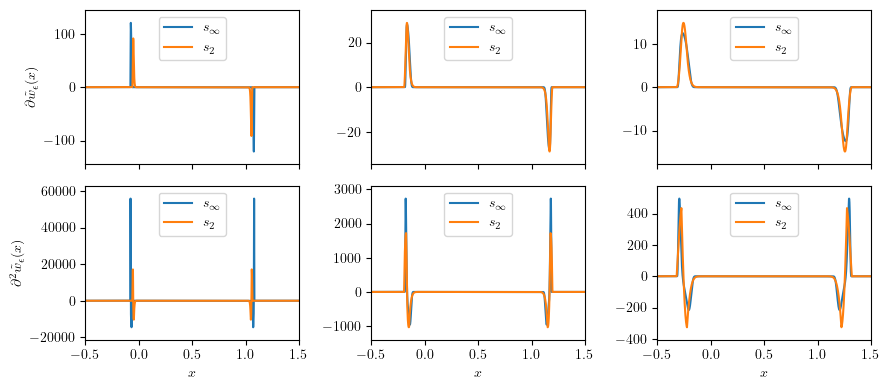

In [ ]:
import functools
import numpy as np


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 4), sharex=True) 


for i in range(2):
    for j, eps_str in enumerate(['1e-3', '1e-1', '5e-1']):
        eps = float(eps_str)
        xs = jnp.linspace(-0.5, 1.5, 100000)
        
        grad_inf_func = jax.grad(functools.partial(weight, smoothed_step, eps))
        grad_two_func = jax.grad(functools.partial(weight, two_step, eps))
        if i > 0:
            grad_inf_func = jax.grad(grad_inf_func)
            grad_two_func = jax.grad(grad_two_func)

        w_lamb_inf_xs = jax.vmap(grad_inf_func)(xs)
        w_lamb_two_xs = jax.vmap(grad_two_func)(xs)
        axes[i,j].plot(xs, w_lamb_inf_xs, label=r'$s_\infty$')
        axes[i,j].plot(xs, w_lamb_two_xs, label=r'$s_2$')
        
        axes[i,j].vlines([0.,1.], jnp.min(w_lamb_two_xs), jnp.max(jnp.min(w_lamb_two_xs)), colors='black', linestyles='dotted')
        axes[i,j].legend(loc='upper center')
        axes[i,j].set_xlim([-0.5,1.5])

        ymin = min(jnp.min(w_lamb_inf_xs), jnp.min(w_lamb_two_xs))
        ymax = max(jnp.max(w_lamb_inf_xs), jnp.max(w_lamb_two_xs))
        yrange = ymax - ymin
        ypad = yrange * 0.1
        axes[i,j].set_ylim([ymin - ypad, ymax + ypad])

for i, label in enumerate([r'$\partial \tilde w_\epsilon(x)$', r'$\partial^2 \tilde w_\epsilon(x)$']):
    axes[i,0].set_ylabel(label)

for j in range(3):
    axes[1,j].set_xlabel(r'$x$')

fig.tight_layout()
plt.savefig(f'weights_grad_1d.pdf')

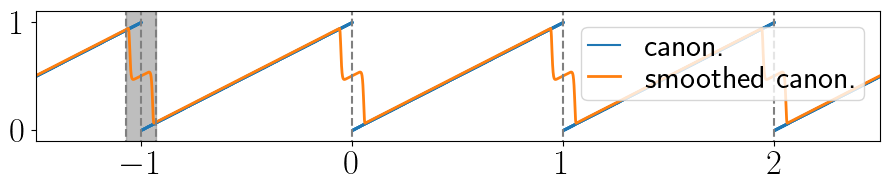

In [34]:
import jax.numpy as jnp 
import jax 
import matplotlib.pyplot as plt


xs = jnp.linspace(-1.5, 2.5, 10000)
eps = 0.001
canon = lambda x: x % 1

def smoothed_canon(step_func, eps, x):
    ys = jnp.array([x % 1 - 1, x % 1, x % 1 + 1])
    ws = jax.vmap(lambda y: weight(step_func, eps, y))(ys)
    return jnp.sum(ws * ys / jnp.sum(ws))


fig, ax = plt.subplots(figsize=(9,2))
ax.plot(xs, jax.vmap(canon)(xs), '.', markersize=1)
ax.plot([-2],[-1],color='tab:blue',label='canon.')
ax.plot(xs, jax.vmap(lambda x: smoothed_canon(two_step, eps, x))(xs), '-', linewidth=2, label='smoothed canon.')

ax.vlines([-1.,0.,1.,2.], -1, 2, linestyle='dashed', color='gray')
ax.vlines([-1.07,-1+.07], -1, 2, linestyle='dashed', color='tab:gray')
ax.axvspan(-1.07,-1+.07,alpha=0.5,color='tab:gray')

legend = ax.legend(loc='upper right',fontsize=23,labelspacing=0.1,handlelength=1,borderpad=0.2)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-1.5,2.5])

ax.tick_params(axis='both', which='major', labelsize=25)

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))

plt.tight_layout()


plt.savefig('canon_1d.pdf')


